# Network analysis for error-related brain activity and anxiety dimensions using GGlasso python package

> https://gglasso.readthedocs.io/en/latest/



### Imports

In [139]:
import os
import sys
import re
import glob
import ast
import os.path as op
import pickle
import mne
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

from collections import defaultdict

from gglasso.problem import glasso_problem

from copy import deepcopy
import copy

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import covariance


from gglasso.problem import glasso_problem

from autoreject import AutoReject

from transformers import *

import warnings
warnings.filterwarnings("ignore")

---
## Load data

Loading EEG data and data from rumination questionnaire. By default create_df_data loads all info from given file but one can specify it by passing a list of desired labels from csv file.

In [4]:
# paths TODO
dir_path = os.path.dirname(os.path.abspath(""))

In [5]:
tmin, tmax = -0.1, 0.6  # Start and end of the segments
signal_frequency = 256
random_state = 0

In [6]:
def create_df_data(
    test_participants=False,
    test_epochs=False,
    info_filename=None,
    info="all",
    personal=True,
):
    """Loads data for all participants and create DataFrame with optional additional info from given .csv file.

    On default, loads a train set: chooses only 80% of participants
    and for each of them chooses 80% of epochs.
    It will choose them deterministically.

    Participants with less than 10 epochs per condition are rejected.

    If test_participants is set to True, it will load remaining 20% of participants.
    If test_epochs is set to True, it will load remaining 20% of epochs.
    Test epochs are chronologically after train epochs,
    because it reflects real usage (first callibration and then classification).

    Parameters
    ----------
    test_participants: bool
        whether load data for training or final testing.
        If true load participants data for testing.
    test_epochs: bool
        whether load data for training or final testing.
        If true load epochs of each participants data for testing.
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters
    personal: bool
        whether a model will be both trained and tested on epochs from one person
        if false, person's epochs aren't split into test and train


    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    print(os.path.abspath(""))
    dir_path = os.path.dirname(os.path.abspath(""))
    print(dir_path)
    header_files_glob = os.path.join(dir_path, "data/responses_100_600/*.vhdr")
    header_files = glob.glob(header_files_glob)

    header_files = sorted(header_files)
    go_nogo_data_df = pd.DataFrame()

    # cut 20% of data for testing
    h_train, h_test = train_test_split(header_files, test_size=0.3, random_state=0)
    
    print(f"train size: {len(h_train)} ; test size: {len(h_test)}")

    if test_participants:
        header_files = h_test
    else:
        header_files = h_train

    for file in header_files:
        #  load eeg data for given participant
        participant_epochs = load_epochs_from_file(file)

        # and compute participant's id from file_name
        participant_id = re.match(r".*_(\w+).*", file).group(1)

        error = participant_epochs["error_response"]._data
        correct = participant_epochs["correct_response"]._data

        # exclude those participants who have too few samples
        if len(error) < 5 or len(correct) < 5:
            # not enough data for this participant
            continue

        # construct dataframe for participant with: id|epoch_data|response_type|additional info...
        participant_df = create_df_from_epochs(
            participant_id, participant_epochs, info_filename, info
        )
        print(participant_id)
        go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)

    return go_nogo_data_df

In [7]:
def create_df_from_epochs(id, participant_epochs, info_filename, info):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.
    Default info extracted form .csv file is 'Rumination Full Scale' and participants' ids.
    With this info df structure is like:
    {id: String ; epoch: epoch_data ; marker: 1.0|0.0 ; File: id ; 'Rumination Full Scale': int}

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    correct: array
        correct responses' data
    error: array
        error responses' data
    info_filename: String
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """
    participant_df = pd.DataFrame()
    info_df = pd.DataFrame()

    # get additional info from file
    if info_filename is not None:
        if info == "all":
            rumination_df = pd.read_csv(info_filename)
        else:
            rumination_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info)
        info_df = (
            rumination_df.loc[rumination_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )      
    epoch_df = pd.DataFrame({"id": [id], "epoch": [participant_epochs]}).join(
            info_df
        )
    participant_df = participant_df.append(epoch_df, ignore_index=True)

    return participant_df

In [8]:
def load_epochs_from_file(file, reject_bad_segments="auto", mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    event_dict = {
        "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
        "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
        "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
        "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
        "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
        "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
        "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
        "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    }

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct the original events from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        [10004, 10005, 10009, 10010],
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        [10006, 10007, 10008, 10011],
        merged_event_dict["error_response"],
        replace_events=True,
    )

    epochs = []
    bads = []
    this_reject_by_annotation = False
    
    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=this_reject_by_annotation,
        preload=True,
    )
    
    ar = AutoReject(random_state=random_state, n_jobs=10, verbose=0)
    epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)
    
    return epochs_ar

#### Read the data

In [9]:
df_name = "GNG_autoreject_3_5"
# df_name = "GNG_reject_auto_3-5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales_with_rt_edited.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_df.name = df_name
    # save loaded data into a pickle file
    epochs_df.to_pickle("../data/" + epochs_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [10]:
epochs_df.shape

(110, 188)

#### Read data for external testing

In [11]:
# df_name = "go_nogo_100_600_test_df_3-5_all_scales"
# pickled_data_filename = "../data/" + df_name + ".pkl"
# # info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"
# info_filename = "../data/scales/all_scales.csv"


# # Check if data is already loaded
# if os.path.isfile(pickled_data_filename):
#     print("Pickled file found. Loading pickled data...")
#     epochs_test_df = pd.read_pickle(pickled_data_filename)
#     print("Done")
# else:
#     print("Pickled file not found. Loading data...")
#     epochs_test_df = create_df_data(
#         test_participants=True, info="all", personal=False, info_filename=info_filename
#     )
#     epochs_test_df.name = df_name
#     # save loaded data into a pickle file
#     epochs_test_df.to_pickle("../data/" + epochs_test_df.name + ".pkl")
#     print("Done. Pickle file created")

## Create Net

#### Extract EEG features

 1. PCA
 
 - ROI
 - time window: -100 to 200 ms
 - PCA(n=4)
 - binning: 47ms (12 tp)
 - Centering
 - peak-to-peak amplitude

In [12]:
timepoints_count = 78
spatial_filter_components = 4
bin_width = 12
roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

In [13]:
class CenteredSignalAfterBaseline_this(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        search_start_bin = 2

        search_data = np.array(
            [
                participant.take(indices=range(search_start_bin, 5), axis=1)
                for participant in X
            ]
        )

        signal_max_positions = np.array(
            [search_start_bin + np.argmax(epoch[1]) for epoch in search_data]
        )

        # print(signal_max_positions)

        X_index_zip = zip(X, signal_max_positions)

        centered_data = []
        for participant, index in X_index_zip:
            # print(f"participant{participant}, index {index}")
            centered_data.append(
                participant.take(indices=range(index - 2, index + 1), axis=1)
            )
        centered_data = np.array(centered_data)

        return centered_data

In [14]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-0.1, tmax=0.20)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
    ("spatial_filter",PCA(n_components=spatial_filter_components, random_state=random_state)),
    ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=timepoints_count)),
    ("lowpass_filter", LowpassFilter()),
    ("binning", BinTransformer(step=12)),
    ("centering", CenteredSignalAfterBaseline_this()),
    ("ern_data_extraction", ErnTransformer(stop_ern_bin=3)),
    ("peak-to-peak", ErnAmplitude2()),
]).fit(epochs_df_copy)

preprocessed_X_PCA_12bins = pipeline.transform(epochs_df_copy)

preprocessed_X_PCA_12bins = preprocessed_X_PCA_12bins.reshape(preprocessed_X_PCA_12bins.shape[0], -1)

IN PE RETURN SHAPE: (228, 13, 78)
(110, 13, 78)
IN PE RETURN SHAPE: (228, 13, 78)
(110, 13, 78)


In [15]:
preprocessed_X_PCA_12bins.shape

(110, 4)

In [16]:
# sns.set(rc={'figure.figsize':(20 , 20)})

# for i in range(0,40):
#     plt.plot(preprocessed_X[i,1,:])

 2. PCA smaller bins
 
 - ROI
 - time window: -100 to 200 ms
 - PCA(n=4)
 - binning: 24ms (6 tp)
 - Centering
 - peak-to-peak amplitude

In [17]:
timepoints_count = 78
spatial_filter_components = 4
bin_width = 6
roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

In [18]:
class CenteredSignalAfterBaseline_this2(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        search_start_bin = 4

        search_data = np.array(
            [
                participant.take(indices=range(search_start_bin, 10), axis=1)
                for participant in X
            ]
        )

        signal_max_positions = np.array(
            [search_start_bin + np.argmax(epoch[1]) for epoch in search_data]
        )

        # print(signal_max_positions)

        X_index_zip = zip(X, signal_max_positions)

        centered_data = []
        for participant, index in X_index_zip:
            # print(f"participant{participant}, index {index}")
            centered_data.append(
                participant.take(indices=range(index - 4, index+2), axis=1)
            )
        centered_data = np.array(centered_data)

        return centered_data

In [19]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-0.1, tmax=0.20)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
    ("spatial_filter",PCA(n_components=spatial_filter_components, random_state=random_state)),
    ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=timepoints_count)),
    ("lowpass_filter", LowpassFilter()),
    ("binning", BinTransformer(step=6)),
    ("centering", CenteredSignalAfterBaseline_this2()),
    ("ern_data_extraction", ErnTransformer(stop_ern_bin=5)),
    ("peak-to-peak", ErnAmplitude2()),
]).fit(epochs_df_copy)

preprocessed_X_PCA_6bins = pipeline.transform(epochs_df_copy)

preprocessed_X_PCA_6bins = preprocessed_X_PCA_6bins.reshape(preprocessed_X_PCA_6bins.shape[0], -1)

IN PE RETURN SHAPE: (228, 13, 78)
(110, 13, 78)
IN PE RETURN SHAPE: (228, 13, 78)
(110, 13, 78)


In [20]:
preprocessed_X_PCA_6bins.shape

(110, 4)

In [21]:
# sns.set(rc={'figure.figsize':(20 , 20)})

# for i in range(0,90):
#     plt.plot(preprocessed_X_2[i,1,:])

 3. ERN bins
 
 - ROI
 - time window: -100 to 200 ms
 - binning: 24ms (6 tp)
 - Centering
 - peak-to-peak

In [22]:
timepoints_count = 78
spatial_filter_components = 4
bin_width = 6
roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

In [23]:
class CenteredSignalAfterBaseline_ern(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        search_start_bin = 4

        search_data = np.array(
            [
                participant.take(indices=range(search_start_bin, 10), axis=1)
                for participant in X
            ]
        )

        signal_max_positions = np.array(
            [search_start_bin + np.argmin(epoch[3]) for epoch in search_data]
        )

        # print(signal_max_positions)

        X_index_zip = zip(X, signal_max_positions)

        centered_data = []
        for participant, index in X_index_zip:
            # print(f"participant{participant}, index {index}")
            centered_data.append(
                participant.take(indices=range(index - 4, index+2), axis=1)
            )
        centered_data = np.array(centered_data)

        return centered_data

In [24]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-0.1, tmax=0.20)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("lowpass_filter", LowpassFilter()),
    ("binning", BinTransformer(step=6)),
    ("centering", CenteredSignalAfterBaseline_ern()),
    ("ern_data_extraction", ErnTransformer(start_ern_bin=1, stop_ern_bin=6)),
    ("peak-to-peak", ErnAmplitude2()),
]).fit(epochs_df_copy)

preprocessed_X_ERN_6bins_ptp = pipeline.transform(epochs_df_copy)

preprocessed_X_ERN_6bins_ptp = preprocessed_X_ERN_6bins_ptp.reshape(preprocessed_X_ERN_6bins_ptp.shape[0], -1)

IN PE RETURN SHAPE: (228, 13, 78)
(110, 13, 78)
IN PE RETURN SHAPE: (228, 13, 78)
(110, 13, 78)


In [25]:
preprocessed_X_ERN_6bins_ptp.shape

(110, 13)

In [26]:
# sns.set(rc={'figure.figsize':(20 , 20)})

# for i in range(0,90):
#     plt.plot(preprocessed_X_3[i,1,:])

 4. ERN bins
 
 - ROI
 - time window: -100 to 200 ms
 - binning: 24ms (6 tp)
 - Centering
 - mean

In [27]:
timepoints_count = 78
spatial_filter_components = 4
bin_width = 6
roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

In [28]:
class CenteredSignalAfterBaseline_ern(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        search_start_bin = 4

        search_data = np.array(
            [
                participant.take(indices=range(search_start_bin, 10), axis=1)
                for participant in X
            ]
        )

        signal_max_positions = np.array(
            [search_start_bin + np.argmin(epoch[3]) for epoch in search_data]
        )

        # print(signal_max_positions)

        X_index_zip = zip(X, signal_max_positions)

        centered_data = []
        for participant, index in X_index_zip:
            # print(f"participant{participant}, index {index}")
            centered_data.append(
                participant.take(indices=range(index - 4, index+2), axis=1)
            )
        centered_data = np.array(centered_data)

        return centered_data

In [29]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-0.1, tmax=0.20)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("lowpass_filter", LowpassFilter()),
    ("binning", BinTransformer(step=6)),
    ("centering", CenteredSignalAfterBaseline_ern()),
    ("ern_data_extraction", ErnTransformer(start_ern_bin=1, stop_ern_bin=6)),
    ("mean_amplitude", AverageSignal()),
]).fit(epochs_df_copy)

preprocessed_X_ERN_6bins_mean = pipeline.transform(epochs_df_copy)

preprocessed_X_ERN_6bins_mean = preprocessed_X_ERN_6bins_mean.reshape(preprocessed_X_ERN_6bins_mean.shape[0], -1)

IN PE RETURN SHAPE: (228, 13, 78)
(110, 13, 78)
IN PE RETURN SHAPE: (228, 13, 78)
(110, 13, 78)


In [30]:
preprocessed_X_ERN_6bins_mean.shape

(110, 13)

In [31]:
# sns.set(rc={'figure.figsize':(20 , 20)})

# for i in range(0,90):
#     plt.plot(preprocessed_X_ERN_6bins_mean[i,1,:])

 5. ERN bins ROIs
 
 - ROI: frontal, 2X lateral. central, parietal
 - time window: -100 to 200 ms
 - binning: 24ms (6 tp)
 - Centering
 - mean and ptp

In [32]:
timepoints_count = 78
spatial_filter_components = 4
bin_width = 6

roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FC1", "FCz", "FC2",
    "C1", "Cz","C2",
    "CP1", "CPz", "CP2",
    "P1", "Pz", "P2",
]

frontal_indexes = [0,1,3]
right_indexes = [2, 5, 8, 11]
left_indexes = [4, 7, 10, 13]
central_indexes = [6,9]
parietal_indexes = [12, 14, 15, 16]

In [33]:
class CenteredSignalAfterBaseline_ern(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        search_start_bin = 4

        search_data = np.array(
            [
                participant.take(indices=range(search_start_bin, 10), axis=1)
                for participant in X
            ]
        )

        signal_max_positions = np.array(
            [search_start_bin + np.argmin(epoch[3]) for epoch in search_data]
        )

        # print(signal_max_positions)

        X_index_zip = zip(X, signal_max_positions)

        centered_data = []
        for participant, index in X_index_zip:
            # print(f"participant{participant}, index {index}")
            centered_data.append(
                participant.take(indices=range(index - 4, index+2), axis=1)
            )
        centered_data = np.array(centered_data)

        return centered_data

In [34]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-0.1, tmax=0.20)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("lowpass_filter", LowpassFilter()),
    ("binning", BinTransformer(step=6)),
    ("centering", CenteredSignalAfterBaseline_ern()),
    ("ern_data_extraction", ErnTransformer(start_ern_bin=1, stop_ern_bin=6)),
    # ("mean_amplitude", AverageSignal()),
]).fit(epochs_df_copy)

preprocessed_X_ERN_6bins_mean = pipeline.transform(epochs_df_copy)

# create rois
frontal_roi = np.mean(preprocessed_X_ERN_6bins_mean[:,frontal_indexes,:], axis=1)
right_roi = np.mean(preprocessed_X_ERN_6bins_mean[:,right_indexes,:], axis=1)
left_roi = np.mean(preprocessed_X_ERN_6bins_mean[:,left_indexes,:], axis=1)
central_roi = np.mean(preprocessed_X_ERN_6bins_mean[:,central_indexes,:], axis=1)
parietal_roi = np.mean(preprocessed_X_ERN_6bins_mean[:,parietal_indexes,:], axis=1)

X_ERN_6bins_roi = np.stack([frontal_roi, right_roi, left_roi, central_roi, parietal_roi], axis=1)

IN PE RETURN SHAPE: (228, 17, 78)
(110, 17, 78)
IN PE RETURN SHAPE: (228, 17, 78)
(110, 17, 78)


Mean

In [35]:
X_ERN_6bins_roi_mean = Pipeline([
    ("mean_amplitude", AverageSignal()), 
]).fit_transform(X_ERN_6bins_roi)

X_ERN_6bins_roi_mean = X_ERN_6bins_roi_mean.reshape(X_ERN_6bins_roi_mean.shape[0], -1)
X_ERN_6bins_roi_mean.shape

(110, 5)

Peak-to-Peak

In [36]:
X_ERN_6bins_roi_ptp = Pipeline([
    ("peak-to-peak", ErnAmplitude2()), 
]).fit_transform(X_ERN_6bins_roi)

X_ERN_6bins_roi_ptp = X_ERN_6bins_roi_ptp.reshape(X_ERN_6bins_roi_ptp.shape[0], -1)
X_ERN_6bins_roi_ptp.shape

(110, 5)

Integral

In [37]:
X_ERN_6bins_roi_integral = []

for subject in X_ERN_6bins_roi:    
    integral_ = sp.integrate.simps(subject, axis=-1).tolist()
    X_ERN_6bins_roi_integral.append(integral_)  
    
X_ERN_6bins_roi_integral = np.array(X_ERN_6bins_roi_integral).reshape(len(X_ERN_6bins_roi_integral), -1) 
X_ERN_6bins_roi_integral.shape

(110, 5)

6. ERN

- ROI: Fz
- time window: 0 - 100 ms
- mean amplitude

In [38]:
roi = [
    "Fz", 
]

In [39]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

ern_pipeline = Pipeline([
   ("channels_extraction",PickChannels(channels_list=['Fz'])),
    ("trim", EpochTrim(tmin=0, tmax=0.1)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("mean_amplitude", AverageSignal()),
    
]).fit(epochs_df_copy)

preprocessed_X_ern = ern_pipeline.transform(epochs_df_copy)

preprocessed_X_ern = preprocessed_X_ern.reshape(preprocessed_X_ern.shape[0], -1)

IN PE RETURN SHAPE: (228, 1, 27)
(110, 1, 27)
IN PE RETURN SHAPE: (228, 1, 27)
(110, 1, 27)


In [40]:
preprocessed_X_ern.shape

(110, 1)

7. ERN latency & peak

- ROI
- time window: 0 - 100 ms
- mean amplitude

In [41]:
# Define a function to print out the channel (ch) containing the
# peak latency (lat; in msec) and amplitude (amp, in µV), with the
# time range (tmin and tmax) that was searched.
# This function will be used throughout the remainder of the tutorial.
def print_peak_measures(ch, tmin, tmax, lat, amp):
    print(f'Channel: {ch}')
    print(f'Time Window: {tmin * 1e3:.3f} - {tmax * 1e3:.3f} ms')
    print(f'Peak Latency: {lat * 1e3:.3f} ms')
    print(f'Peak Amplitude: {amp * 1e6:.3f} µV')

In [42]:
roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FC1", "FCz", "FC2",
]

In [43]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

In [44]:
tmin, tmax = 0, 0.1
latencies = []
peaks = []
chs_type = []

X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=0, tmax=0.1)),
    ("average", Evoked()),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

for subject in X:
    ch, lat, amp = subject[0].get_peak(tmin=tmin, tmax=tmax, mode='neg', return_amplitude=True)
    
    # print_peak_measures(ch, tmin, tmax, lat, amp)
    
    latencies.append(lat)
    peaks.append(amp)
    
    ch_type = 0 if ch[-1] == 'z' else (1 if ch[-1] == '1' else 2)
    
    chs_type.append(ch_type)
    
latencies = np.array(latencies).reshape(len(latencies), -1) 
peaks = np.array(peaks).reshape(len(peaks), -1) 
chs_type = np.array(chs_type).reshape(len(chs_type), -1)    

IN PE RETURN SHAPE: (228, 8, 27)


8. ERN energy/power

- ROI: Fz
- time window: 0 - 100 ms
- mean amplitude

In [45]:
roi = [
   "Fz", 
]

In [46]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

In [47]:
power = []
energy = []

X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-.05, tmax=0.1)),
    ("average", Evoked()),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

for subject in X:
    x = subject[0].get_data()
    x = x.flatten()
    
    time_in_s = x.size/256
    
    # Calculate power over each window [J/s]
    power_ = sp.sum(x*x)/time_in_s
    
    # Calculate energy [J = J/s * 30 second]
    energy_ = power_*time_in_s
    
    power.append(power_)
    energy.append(energy_)
    
power = np.array(power).reshape(len(power), -1) 
energy = np.array(energy).reshape(len(energy), -1) 

IN PE RETURN SHAPE: (228, 1, 40)


9. Integral under the ERN

- ROI: Fz
- time window: 0 - 100 ms
- mean amplitude

In [48]:
roi = [
   "Fz", 
]

In [49]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

In [50]:
integral = []

X = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-.01, tmax=0.1)),
    ("average", Evoked()),
]).fit_transform(epochs_df_copy)

X = X[['evoked']].to_numpy()

for subject in X:
    x = subject[0].get_data()
    x = x.flatten()
    
    integral_ = sp.integrate.simps(x)
    integral.append(integral_)    
    
integral = np.array(integral).reshape(len(integral), -1) 

IN PE RETURN SHAPE: (228, 1, 30)


 10. PCA smaller bins Integral
 
 - ROI
 - time window: -100 to 200 ms
 - PCA(n=4)
 - binning: 24ms (6 tp)
 - Centering
 - Integral

In [51]:
timepoints_count = 78
spatial_filter_components = 4
bin_width = 6
roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

In [52]:
class CenteredSignalAfterBaseline_this2(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        search_start_bin = 4

        search_data = np.array(
            [
                participant.take(indices=range(search_start_bin, 10), axis=1)
                for participant in X
            ]
        )

        signal_max_positions = np.array(
            [search_start_bin + np.argmax(epoch[1]) for epoch in search_data]
        )

        # print(signal_max_positions)

        X_index_zip = zip(X, signal_max_positions)

        centered_data = []
        for participant, index in X_index_zip:
            # print(f"participant{participant}, index {index}")
            centered_data.append(
                participant.take(indices=range(index - 4, index+2), axis=1)
            )
        centered_data = np.array(centered_data)

        return centered_data

In [53]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

PCA_integral = []

pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("trim", EpochTrim(tmin=-0.1, tmax=0.20)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
    ("spatial_filter",PCA(n_components=spatial_filter_components, random_state=random_state)),
    ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=timepoints_count)),
    ("lowpass_filter", LowpassFilter()),
    ("binning", BinTransformer(step=6)),
    ("centering", CenteredSignalAfterBaseline_this2()),
    ("ern_data_extraction", ErnTransformer(stop_ern_bin=5)),
]).fit(epochs_df_copy)

X_ = pipeline.transform(epochs_df_copy)
print(X_.shape)

for subject in X_:    
    integral_ = sp.integrate.simps(subject, axis=-1).tolist()
    PCA_integral.append(integral_)  
    
PCA_integral = np.array(PCA_integral).reshape(len(PCA_integral), -1) 

IN PE RETURN SHAPE: (228, 13, 78)
(110, 13, 78)
IN PE RETURN SHAPE: (228, 13, 78)
(110, 13, 78)
(110, 4, 5)


In [54]:
PCA_integral.shape

(110, 4)

#### Extract questionnaires scores

Questionnaires to include in analysis

In [55]:
# shape 1-D: scores
rumination = "16-Rumination Full Scale"
dass_anxiety = "05-DASS-21 Anxiety scale"
stai_t = "04-STAI Trait SUM" 
bis = "07-BIS"
bas_dzialanie = "07-BAS Dzialanie"
bas_przyjemnosc = "07-BAS Poszukiwanie przyjemnosci"
bas_nagroda = "07-BAS Wrazliwosc na nagrode"
washing = "14-Obsessive-Compulsive WASHING"
obsessing = "14-Obsessive-Compulsive OBSESSING"
hoarding = "14-Obsessive-Compulsive HOARDING"
ordering = "14-Obsessive-Compulsive ORDERING"
checking = "14-Obsessive-Compulsive CHECKING"
neutralizing = "14-Obsessive-Compulsive NEUTRALIZING"
oci_r_full = "14-Obsessive-Compulsive FULL"
threat = "15-Obsessional Beliefs - Overestimation of threat"
perfectionism_IU = "15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty"
thought_suppression = "18-Thought Suppression Inventory"
nonforgivness = "22-Nonforgiveness - Full Scale"
indecisivness = "27-Indecisiveness Scale_Frost"
IU_prospecitve = "28-Intolerance of Uncertainty - Prospective Anxiety"
IU_inhibitory = "28-Intolerance of Uncertainty - Inhibitory Anxiety"
self_esteem = "06-Self-Esteem Scale_SES Rosenberga"

In [56]:
scales = [
    rumination,
    dass_anxiety,
    stai_t,
    bis,
    bas_dzialanie,
    bas_przyjemnosc,
    bas_nagroda,
    washing,
    obsessing,
    hoarding,
    ordering,
    checking,
    neutralizing,
    # oci_r_full,
    threat,
    perfectionism_IU,
    thought_suppression,
    IU_prospecitve,
    IU_inhibitory,
    self_esteem,
]

In [57]:
questionnaires_scores_df = epochs_df[scales]
questionnaires_scores_df.head()

,16-Rumination Full Scale,05-DASS-21 Anxiety scale,04-STAI Trait SUM,07-BIS,07-BAS Dzialanie,07-BAS Poszukiwanie przyjemnosci,07-BAS Wrazliwosc na nagrode,14-Obsessive-Compulsive WASHING,14-Obsessive-Compulsive OBSESSING,14-Obsessive-Compulsive HOARDING,14-Obsessive-Compulsive ORDERING,14-Obsessive-Compulsive CHECKING,14-Obsessive-Compulsive NEUTRALIZING,15-Obsessional Beliefs - Overestimation of threat,15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty,18-Thought Suppression Inventory,28-Intolerance of Uncertainty - Prospective Anxiety,28-Intolerance of Uncertainty - Inhibitory Anxiety,06-Self-Esteem Scale_SES Rosenberga
0,2.17,1.43,31,2.43,2.75,2.75,4.0,1.00,2.33,1.00,4.67,4.00,1.67,3.0,5.2,3.40,3.00,1.2,3.7
1,1.33,2.57,38,2.86,2.75,2.25,3.6,1.33,1.67,1.67,4.00,2.67,1.00,1.6,3.8,3.60,1.71,1.4,3.5
2,4.25,1.57,47,3.57,2.00,2.00,3.2,1.00,1.33,2.67,1.00,2.33,2.00,2.2,3.2,4.07,3.43,2.4,3.5
3,2.67,1.71,36,1.86,3.25,3.25,3.4,2.33,1.67,1.00,2.33,2.67,1.00,1.8,4.6,5.00,2.86,1.8,3.9
4,4.58,2.00,42,2.43,2.50,3.25,3.2,1.00,3.00,1.00,1.00,1.00,1.00,4.6,4.0,2.87,2.43,2.2,3.3


In [58]:
questionnaires_scores_df = questionnaires_scores_df.fillna(questionnaires_scores_df.mean())

#### Concatenate questionnaire and EEG features

Define EEG features (columns)

In [482]:
# add EEG features
eeg_columns_pca_12bins = ['e_PCA_1_12', 'e_PCA_2_12', 'e_PCA_3_12', 'e_PCA_4_12']
eeg_columns_pca_6bins = ['e_PCA_1_6', 'e_PCA_2_6', 'e_PCA_3_6', 'e_PCA_4_6']

eeg_columns_ern_ptp = ['e_Ch_1_p', 'e_Ch_2_p', 'e_Ch_3_p', 'e_Ch_4_p', 'e_Ch_5_p', 'e_Ch_6_p', 'e_Ch_7_p', 'e_Ch_8_p', 'e_Ch_9_p', 'e_Ch_10_p', 'e_Ch_11_p', 'e_Ch_12_p', 'e_Ch_13_p']
eeg_columns_ern_mean = ['e_Ch_1_m', 'e_Ch_2_m', 'e_Ch_3_m', 'e_Ch_4_m', 'e_Ch_5_m', 'e_Ch_6_m', 'e_Ch_7_m', 'e_Ch_8_m', 'e_Ch_9_m', 'e_Ch_10_m', 'e_Ch_11_m', 'e_Ch_12_m', 'e_Ch_13_m']

eeg_columns_ern = ['e_ERN']

eeg_colums_ern_rois_ptp = ['e_frontal_ptp', 'e_right_ptp', 'e_left_ptp', 'e_central_ptp', 'e_parietal_ptp']
eeg_colums_ern_rois_mean = ['e_frontal_mean', 'e_right_mean', 'e_left_mean', 'e_central_mean', 'e_parietal_mean']
eeg_columns_ern_rois_integral = ['e_frontal_int', 'e_right_int', 'e_left_int', 'e_central_int', 'e_parietal_int']

eeg_column_latencies = ['e_Lat']
eeg_column_peak = ['e_Peak']
eeg_column_ch_type = ['e_Lateral']

eeg_column_power = ['e_Power']
eeg_column_energy = ['e_Energy']
eeg_column_integral = ['e_Integral']

eeg_column_PCA_integral = ['e_PCA_1_INT', 'e_PCA_2_INT', 'e_PCA_3_INT', 'e_PCA_4_INT']

In [483]:
results_df = pd.DataFrame()

results_df[eeg_columns_ern] = preprocessed_X_ern # simple mean amp of ERN in 0 -100 ms
# results_df[eeg_columns_pca_12bins] = preprocessed_X_PCA_12bins
results_df[eeg_columns_pca_6bins] = preprocessed_X_PCA_6bins
# results_df[eeg_columns_ern_ptp] = preprocessed_X_ERN_6bins_ptp # peak to peak centerd binned per channels in ROI
# results_df[eeg_columns_ern_mean] = preprocessed_X_ERN_6bins_mean # mean amp centerd binned per channels in ROI
results_df[eeg_colums_ern_rois_ptp] = X_ERN_6bins_roi_ptp # peak to peak centerd binned per frontal; left; right; central; parietal ROIS
results_df[eeg_colums_ern_rois_mean] = X_ERN_6bins_roi_mean # mean amp centerd binned per frontal; left; right; central; parietal ROIS
# results_df[eeg_columns_ern_rois_integral] = X_ERN_6bins_roi_integral # niespecjalnie coś dodaje

results_df[eeg_column_latencies] = latencies # latency of the largest amplitude within channels in ms
# results_df[eeg_column_peak] = peaks # the largest amplitude within channels
results_df[eeg_column_ch_type] = chs_type # the biggest peak on the central || left || right channels 
# results_df[eeg_column_power] = power # power of the claccic ERN 
# results_df[eeg_column_energy] = energy # energy of the classic ERN
# results_df[eeg_column_integral] = integral # integral under the of the classic ERN
results_df[eeg_column_PCA_integral] = PCA_integral # integral under the of the classic ERN


# add questionnaires
results_df = pd.concat([results_df, questionnaires_scores_df], axis=1)

results_df.head()

,e_ERN,e_PCA_1_6,e_PCA_2_6,e_PCA_3_6,e_PCA_4_6,e_frontal_ptp,e_right_ptp,e_left_ptp,e_central_ptp,e_parietal_ptp,...,14-Obsessive-Compulsive HOARDING,14-Obsessive-Compulsive ORDERING,14-Obsessive-Compulsive CHECKING,14-Obsessive-Compulsive NEUTRALIZING,15-Obsessional Beliefs - Overestimation of threat,15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty,18-Thought Suppression Inventory,28-Intolerance of Uncertainty - Prospective Anxiety,28-Intolerance of Uncertainty - Inhibitory Anxiety,06-Self-Esteem Scale_SES Rosenberga
0,-4.154519e-06,0.000018,0.000018,3.266331e-06,9.046505e-07,0.000003,0.000006,0.000006,0.000007,0.000009,...,1.00,4.67,4.00,1.67,3.0,5.2,3.40,3.00,1.2,3.7
1,-4.350181e-06,0.000007,0.000021,5.739433e-07,1.141406e-06,0.000003,0.000004,0.000006,0.000006,0.000009,...,1.67,4.00,2.67,1.00,1.6,3.8,3.60,1.71,1.4,3.5
2,-1.275030e-05,0.000029,0.000024,6.060041e-06,5.014438e-06,0.000004,0.000013,0.000009,0.000014,0.000015,...,2.67,1.00,2.33,2.00,2.2,3.2,4.07,3.43,2.4,3.5
3,2.483405e-07,0.000015,0.000008,1.892263e-06,1.494104e-06,0.000003,0.000004,0.000004,0.000003,0.000004,...,1.00,2.33,2.67,1.00,1.8,4.6,5.00,2.86,1.8,3.9
4,-2.718409e-06,0.000012,0.000022,9.042516e-06,2.731149e-06,0.000004,0.000005,0.000005,0.000003,0.000013,...,1.00,1.00,1.00,1.00,4.6,4.0,2.87,2.43,2.2,3.3


## Learn a graph structure

Create empirical covariance matrix for the problem object

In [484]:
X = results_df.to_numpy()

# X -= X.mean(axis=0) # data is centered in the model (assume_centered=False)
X /= X.std(axis=0)

n_samples = len(results_df)

In [485]:
empirical_covariance = covariance.empirical_covariance(X, assume_centered=False)

Define a GLasso Problem

In [486]:
g_problem = glasso_problem(empirical_covariance, n_samples, reg_params = {'lambda1':0.05}, latent = False, do_scaling = False)

print(g_problem)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}


Model selection by solving the problem on a range of λ1 values.

In [487]:
lambda1_range =  np.logspace(2, -3, num=30)
modelselect_params = {'lambda1_range': lambda1_range}

g_problem.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.05)

# regularization parameters are set to the best ones found during model selection
print(g_problem.reg_params)

ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 35 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 47 iterations with status: optimal.
ADMM terminated after 36 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 116 iterations with status: optimal.
ADMM terminated after 139 iterations with status: optimal.
ADMM terminated after 161 iterations with status: optimal.
ADMM terminated after 136 iterations with status: optimal.
ADMM terminated after 217 iterations with status: optimal.
ADMM terminated after 326 iterations with status: optimal.
ADMM terminated after 291 iterations with status: optimal.
ADMM terminated after 353 iterations with status: optimal.
ADMM terminated after 494 iterations with status: optimal.
ADMM 

Visualize covariance matrix

In [488]:
covariance_matrix_df = pd.DataFrame(g_problem.solution.sample_covariance_, columns = results_df.columns, index = results_df.columns)
precision_matrix_df = pd.DataFrame(g_problem.solution.precision_, columns = results_df.columns, index = results_df.columns)

In [489]:
columns_dict = {
    "16-Rumination Full Scale": "RRQ",
    "05-DASS-21 Anxiety scale": "DASS-21 Anx",
    "04-STAI Trait SUM": "STAI-T",
    "07-BIS": "BIS",
    "14-Obsessive-Compulsive WASHING": "WASH",
    "14-Obsessive-Compulsive OBSESSING": "OBSESS",
    "14-Obsessive-Compulsive HOARDING": "HOARD",
    "14-Obsessive-Compulsive ORDERING": "ORD",
    "14-Obsessive-Compulsive CHECKING": "CHECK",
    "14-Obsessive-Compulsive NEUTRALIZING": "NEU",
    # "14-Obsessive-Compulsive FULL": "OCI-R",
    "15-Obsessional Beliefs - Overestimation of threat": "OT",
    "18-Thought Suppression Inventory": "WBSI",
    "28-Intolerance of Uncertainty - Prospective Anxiety": "IUS-P",
    "28-Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I",
    "06-Self-Esteem Scale_SES Rosenberga": "SES",
    "07-BAS Dzialanie": 'BAS_D',
    "07-BAS Poszukiwanie przyjemnosci": 'BAS_PRZY',
    "07-BAS Wrazliwosc na nagrode": 'BAS_NAG',
    "15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF',
    "22-Nonforgiveness - Full Scale": 'NONFOR',
    "27-Indecisiveness Scale_Frost": 'INDEC_F',
              }

In [490]:
precision_matrix_df = precision_matrix_df.rename(columns=columns_dict, index=columns_dict)
covariance_matrix_df = covariance_matrix_df.rename(columns=columns_dict, index = columns_dict)

In [491]:
# sns.set(rc={'figure.figsize':(30 , 30)})

# fig = sns.heatmap(
#     data = covariance_matrix_df,
#     annot=True
# )

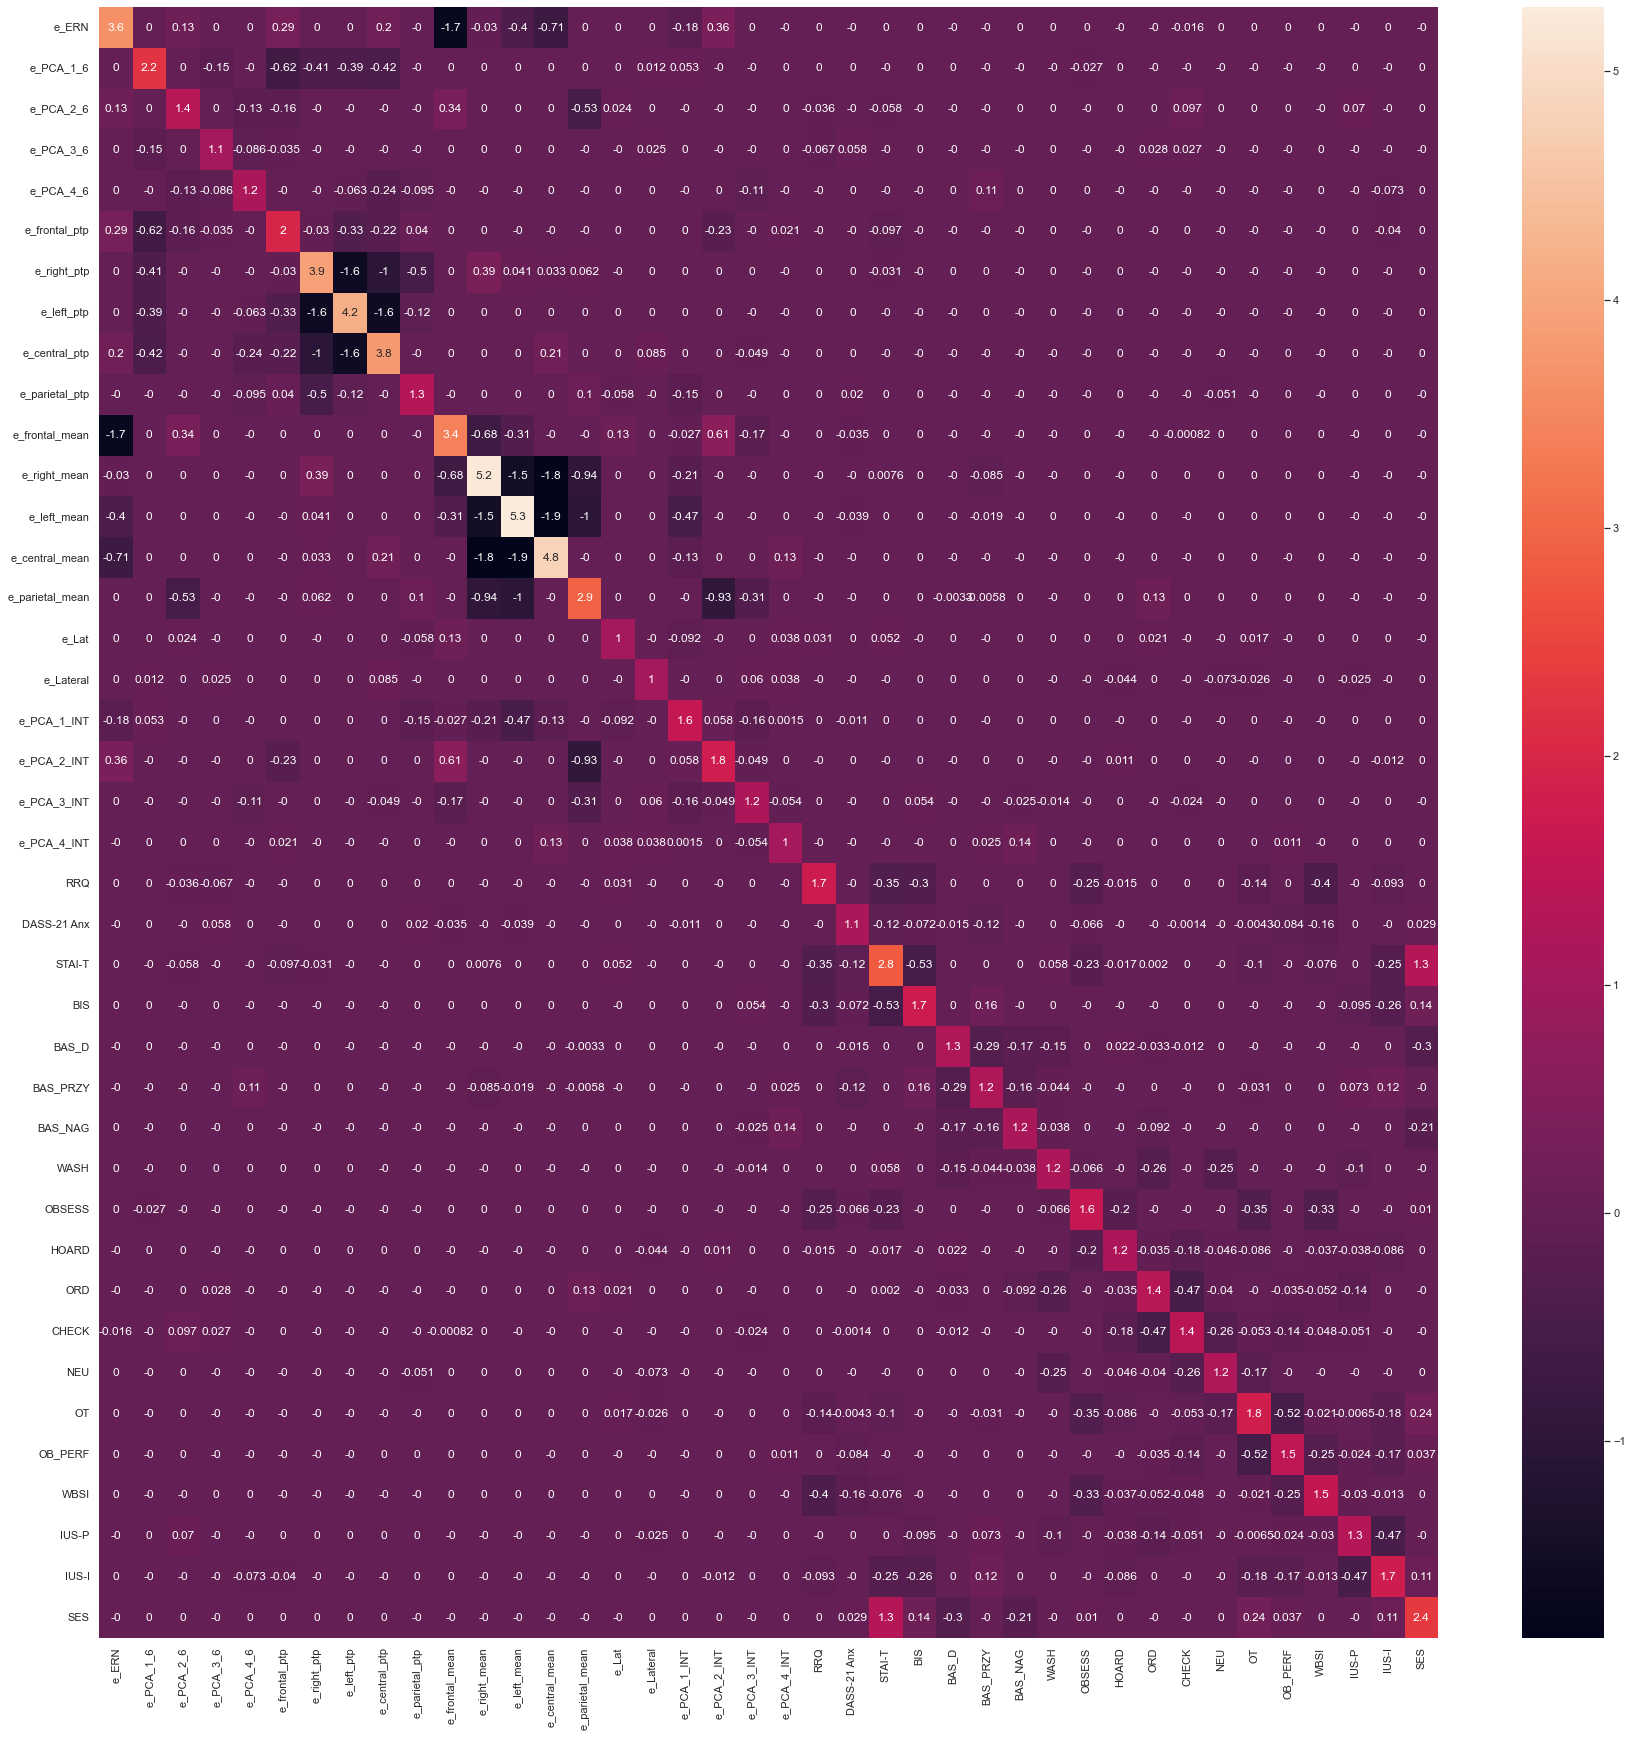

In [492]:
sns.set(rc={'figure.figsize':(30 , 30)})

fig = sns.heatmap(
    data = precision_matrix_df,
    annot=True
)

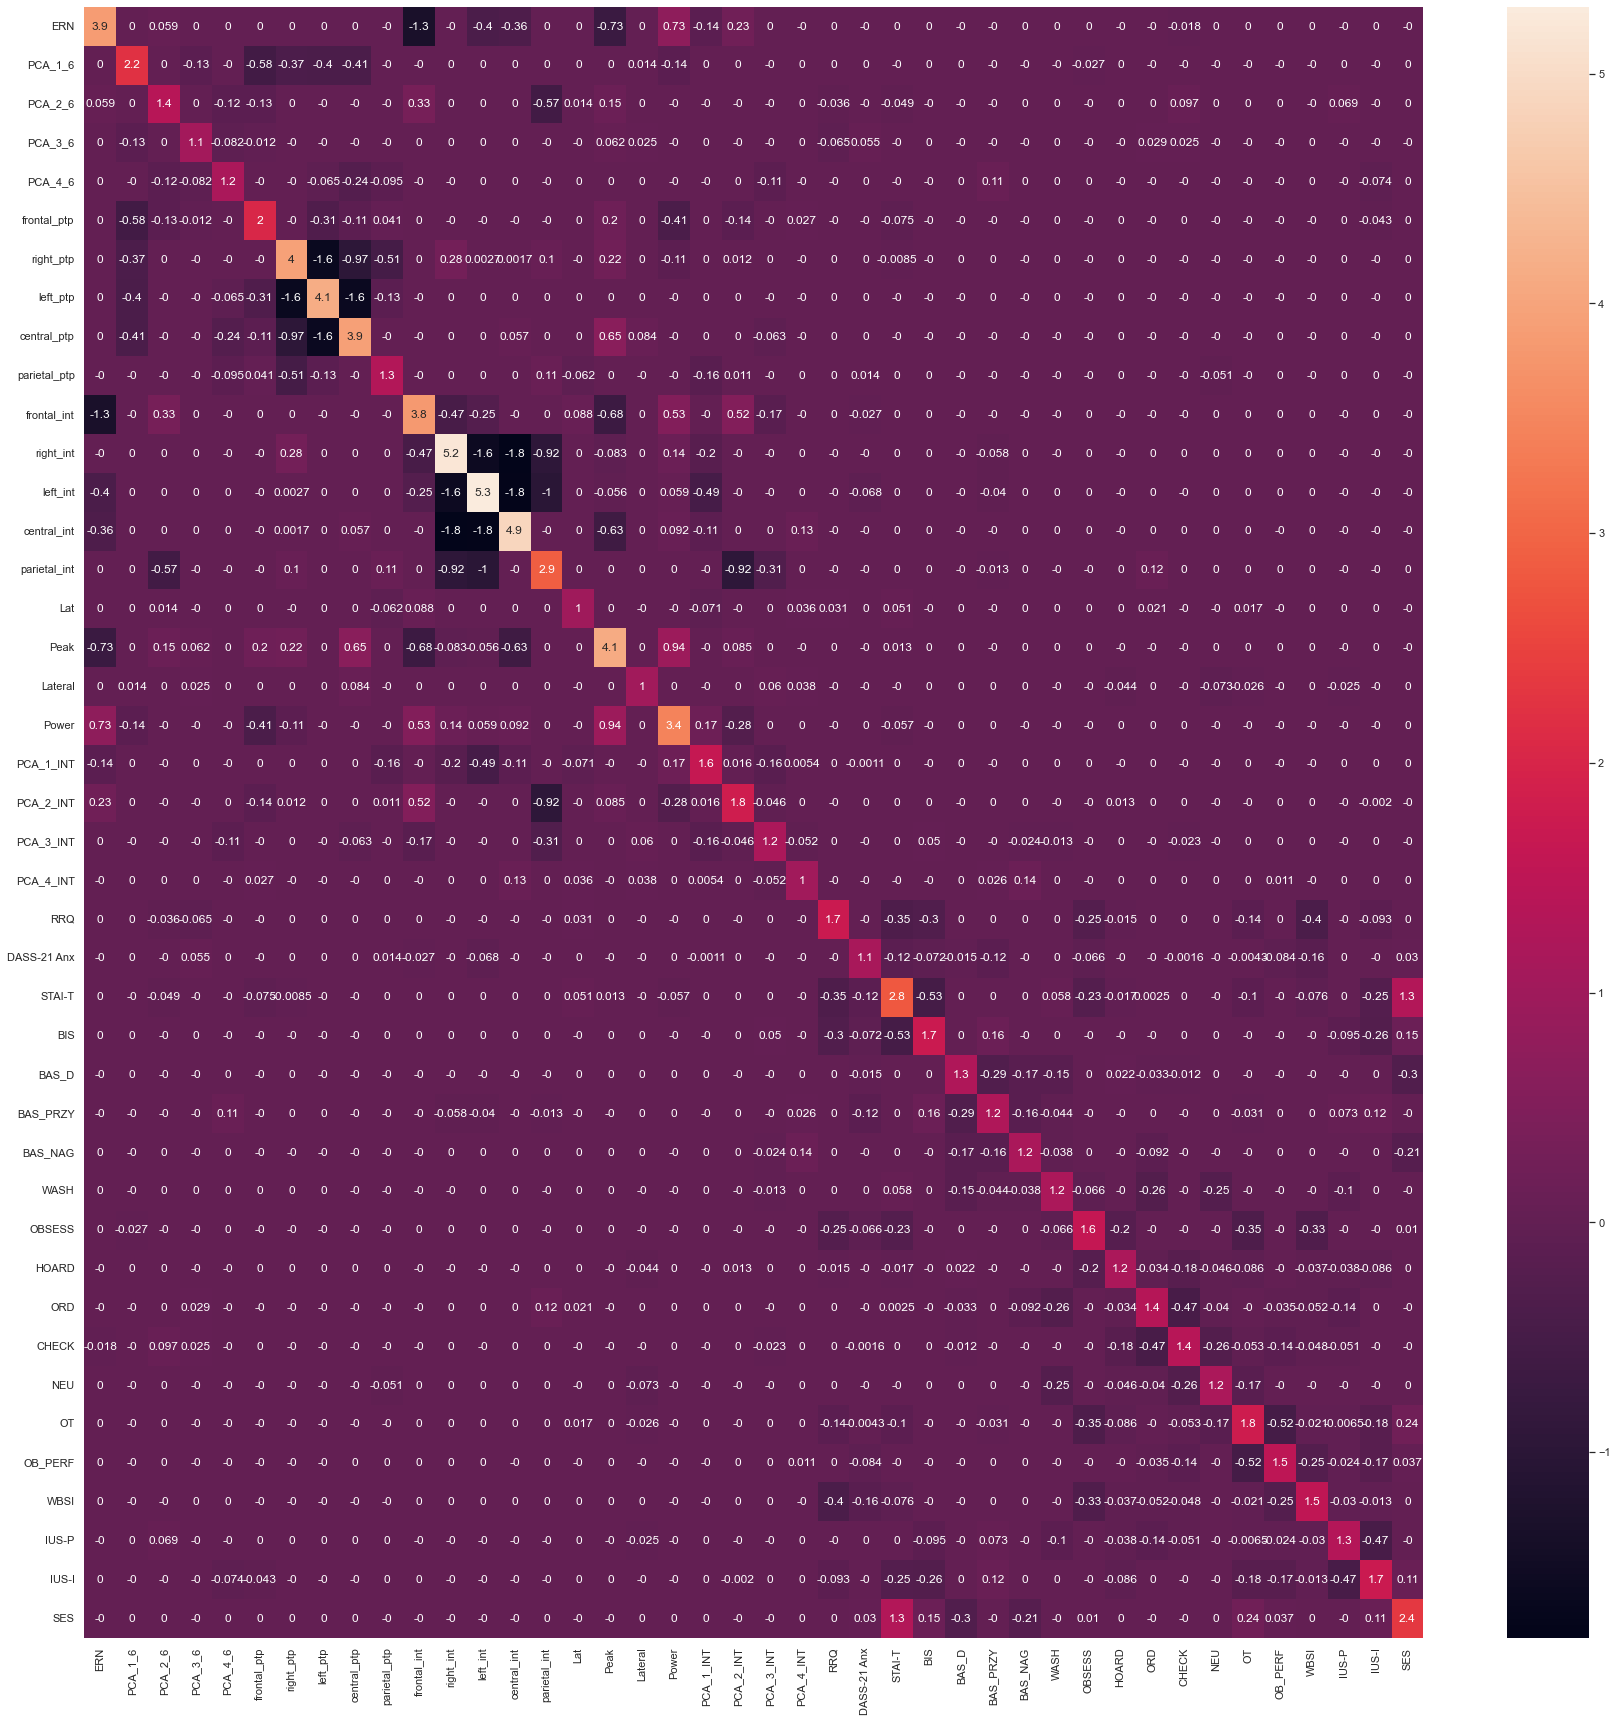

In [410]:
sns.set(rc={'figure.figsize':(30 , 30)})

fig = sns.heatmap(
    data = precision_matrix_df,
    annot=True
)

## Create graph from precision (inverse covariance) matrix

In [503]:
#prepare the matrix for network illustration
links = precision_matrix_df.stack().reset_index()
links.columns = ['var1', 'var2','weight']
links=links.loc[ (abs(links['weight']) > 0.02) &  (links['var1'] != links['var2']) ]

Remove links between various EEG features (for clarity)

In [504]:
links = links[~((links['var1'].str.contains("e_")) & (links['var2'].str.contains("e_")))]

In [505]:
links = links.round(2)
links

,var1,var2,weight
69,e_PCA_1_6,OBSESS,-0.03
101,e_PCA_2_6,RRQ,-0.04
103,e_PCA_2_6,STAI-T,-0.06
112,e_PCA_2_6,CHECK,0.10
117,e_PCA_2_6,IUS-P,0.07
...,...,...,...
1585,SES,BAS_D,-0.30
1587,SES,BAS_NAG,-0.21
1594,SES,OT,0.24
1595,SES,OB_PERF,0.04


In [506]:
#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())

In [514]:
pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)

In [508]:
pos = nx.circular_layout(G)

In [509]:
labels = nx.get_edge_attributes(G,'weight')

In [510]:
edges_list = list(zip(links.var1.to_list(), links.var2.to_list()))
edge_color = [('blue' if edge < 0 else 'red') for edge in links.weight.to_list()]

In [511]:
weights = links.weight.to_list()
weights_alphas = []
weight_bold = []

for edge_weight in weights:
    if abs(edge_weight) < 0.2:
        alpha = 0.2 
        bold = 4
    elif abs(edge_weight) >= 0.2 and abs(edge_weight) < 0.4:
        alpha = 0.4
        bold = 7
    elif abs(edge_weight) >= 0.4 and abs(edge_weight) < 0.7:
        alpha = 0.7
        bold = 10
    else:
        alpha = 0.9
        bold = 15
    weights_alphas.append(alpha)
    weight_bold.append(bold)

Plot graph

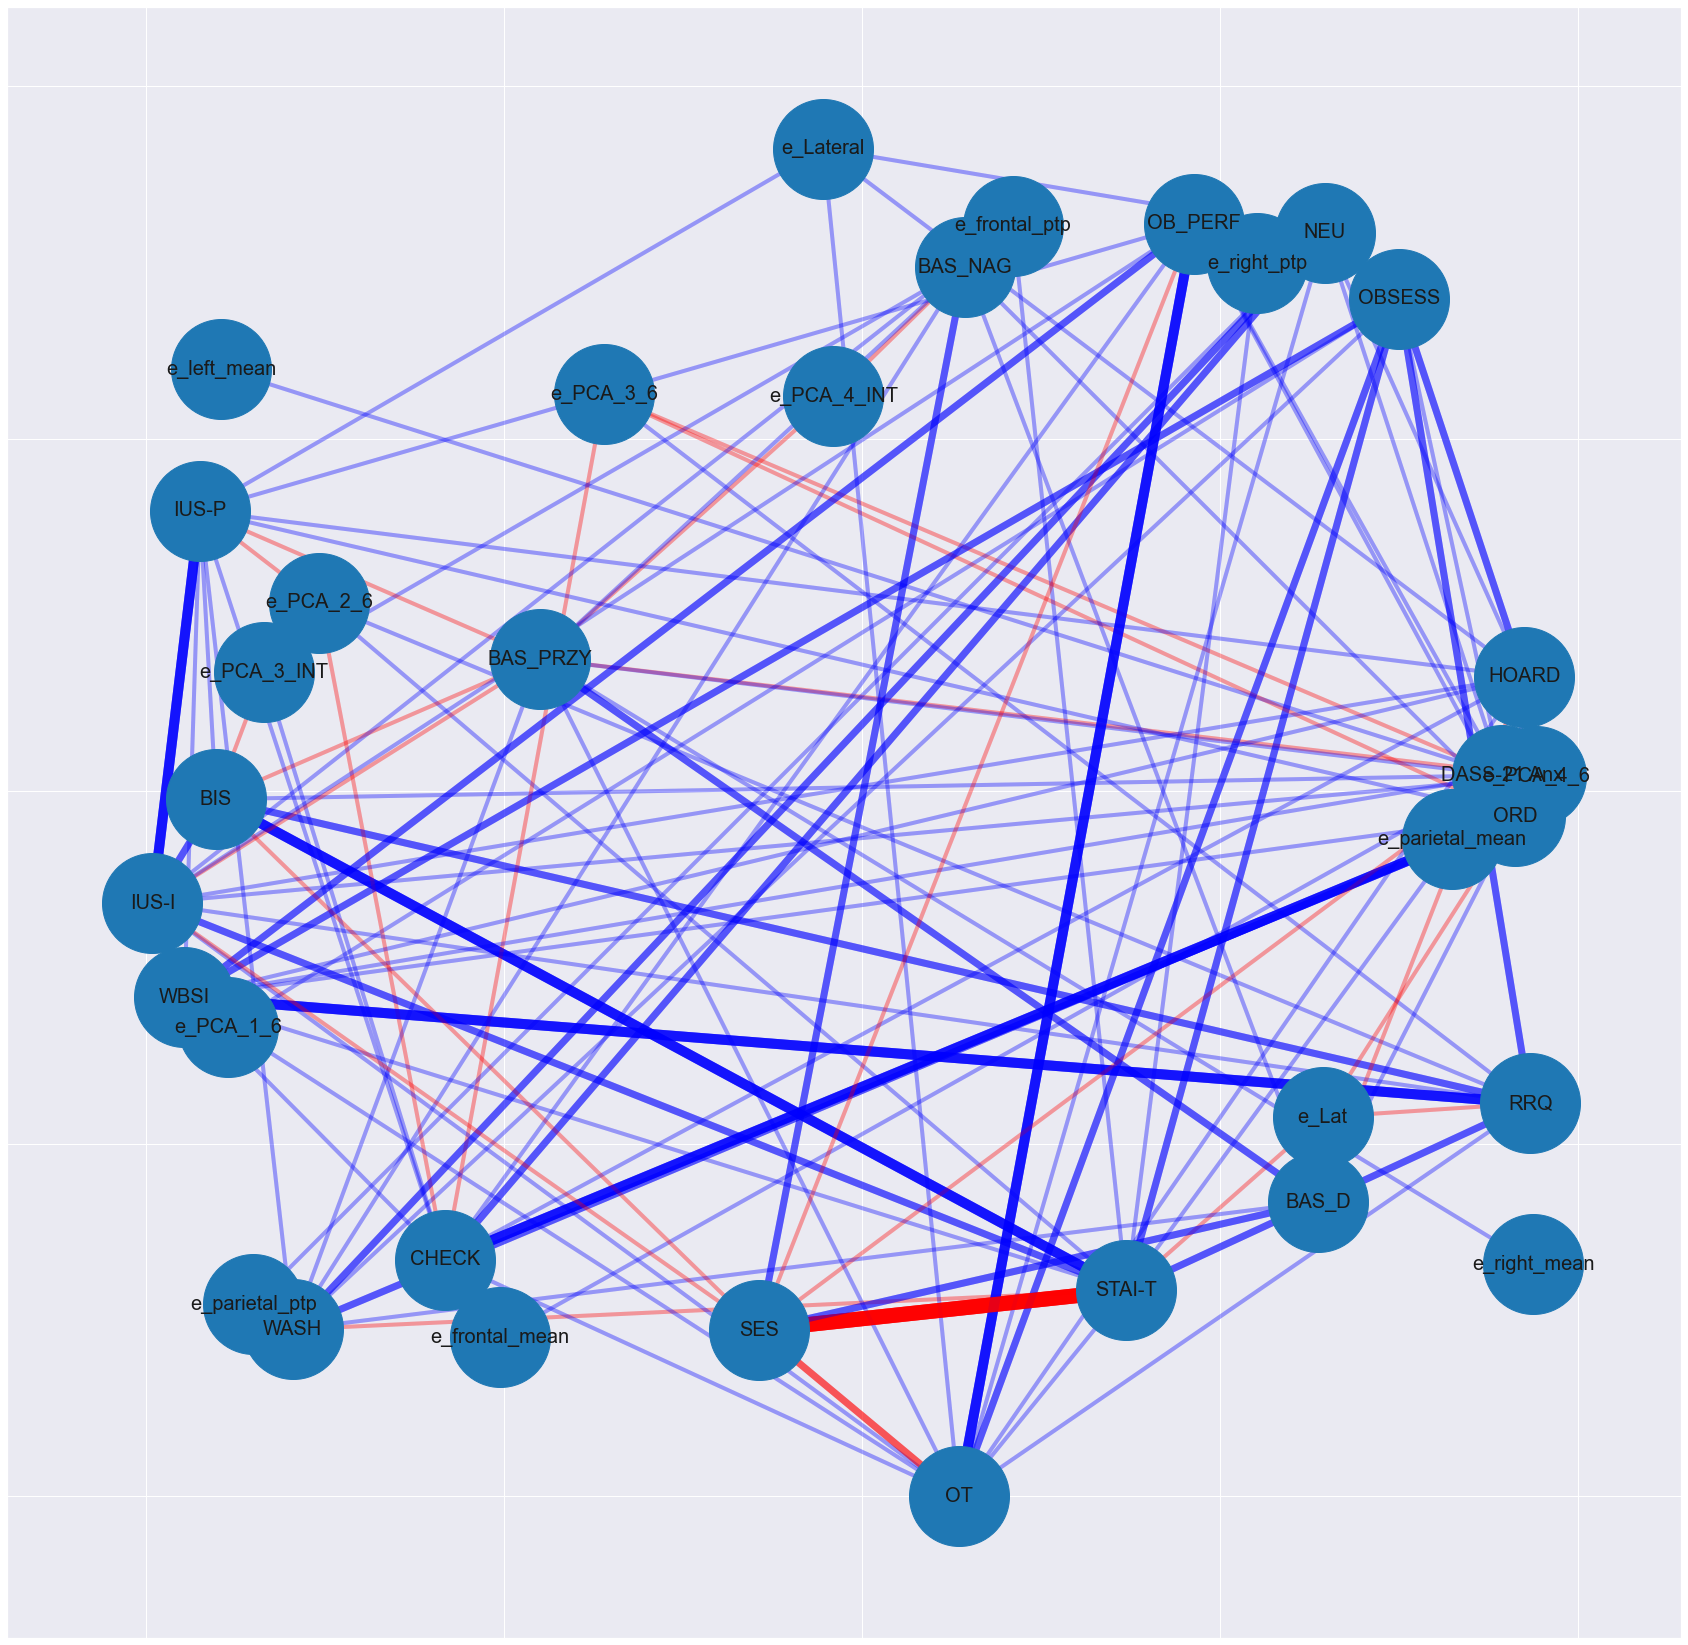

In [515]:
import matplotlib as mpl
plt.figure(3, figsize=(30, 30))



nx.draw_networkx_nodes(
    G, 
    pos=pos, 
    node_size = 10000,
)

nx.draw_networkx_labels(
    G, 
    pos=pos,
    font_size=20,

)

nx.draw_networkx_edges(
    G, 
    pos=pos,
    edgelist = edges_list,
    edge_color = edge_color,
    alpha=weights_alphas,
    width = weight_bold,
)

# nx.draw_networkx_edge_labels(
#     G, 
#     pos=pos, 
#     edge_labels=labels,
#     font_size=20,
# )
plt.show()